## Analyse des performances footballistiques saison par saison

### 1. Chargement et préparation des données

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pipeline Pyspark').getOrCreate()

df = spark.read.csv('../datas/football-matches-68e30d7701b83243515688 - football-matches-68e30d7701b83243515688.csv', 
                   header=True)
df.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/17 08:07:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

+--------+---+------+----------+------------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|          HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+------------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|        Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|       Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|     Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|     Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|             Ahlen|     Karlsruhe|   1|   3|  A|
|       6| D2|  2009|2010-04-03|      Union Berlin|     Karlsruhe|   1|   1|  D|
|       7| D2|  2009|2009-08-14|         Paderborn|     Karlsruhe|   2|   0|  H|
|       8| D2|  2009|2010-03-08|         Bielefeld|     Karlsruhe|   0|   1|  A|
|       9| D2|  2009|2009-09-26|    Kaiserslautern|     Karlsruhe|   2|   0|  H|
|      10| D2|  2009|2009-11

In [2]:
df.printSchema()

root
 |-- Match_ID: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTHG: string (nullable = true)
 |-- FTAG: string (nullable = true)
 |-- FTR: string (nullable = true)



In [3]:
# Conversion du type de la colonne Date
from pyspark.sql.functions import to_timestamp, col, cast, when, round
df = df.withColumn('Date', to_timestamp(col('Date'), 'yyyy-MM-dd'))
df=df.withColumn('FTHG', col("FTHG").cast('int'))
df=df.withColumn('FTAG', col("FTAG").cast('int'))
df=df.withColumn(
    "Season", col("Season").cast('int')
)


df.show(5)

+--------+---+------+-------------------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|               Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+-------------------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04 00:00:00|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01 00:00:00|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04 00:00:00|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21 00:00:00|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06 00:00:00|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+-------------------+-------------+--------------+----+----+---+
only showing top 5 rows


In [4]:
df.printSchema()
df.count()

root
 |-- Match_ID: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTHG: integer (nullable = true)
 |-- FTAG: integer (nullable = true)
 |-- FTR: string (nullable = true)



24625

### 2. Création de colonnes supplémentaires

In [5]:
# Colonnes indicatrices : HomeTeamWin, AwayTeamWin, GameTie.
df = df.withColumn(
    'HomeTeamWin', when(col("FTR") == "H", 1).otherwise(0)
                  ).withColumn(
    "AwayTeamWin", when(col("FTR") == "A", 1).otherwise(0)
                  ).withColumn(
    "GameTie", when(col("FTR") == "D", 1).otherwise(0)
                  )
df.show(5)

+--------+---+------+-------------------+-------------+--------------+----+----+---+-----------+-----------+-------+
|Match_ID|Div|Season|               Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+-------------------+-------------+--------------+----+----+---+-----------+-----------+-------+
|       1| D2|  2009|2010-04-04 00:00:00|   Oberhausen|Kaiserslautern|   2|   1|  H|          1|          0|      0|
|       2| D2|  2009|2009-11-01 00:00:00|  Munich 1860|Kaiserslautern|   0|   1|  A|          0|          1|      0|
|       3| D2|  2009|2009-10-04 00:00:00|Frankfurt FSV|Kaiserslautern|   1|   1|  D|          0|          0|      1|
|       4| D2|  2009|2010-02-21 00:00:00|Frankfurt FSV|     Karlsruhe|   2|   1|  H|          1|          0|      0|
|       5| D2|  2009|2009-12-06 00:00:00|        Ahlen|     Karlsruhe|   1|   3|  A|          0|          1|      0|
+--------+---+------+-------------------+-------------+---------

### 3. Filtrage des données

In [6]:
# Garder uniquement la Bundesliga (Div = D1).

df = df.filter(col("DIV") == "D1")
df.show(10)

+--------+---+------+-------------------+-------------+----------+----+----+---+-----------+-----------+-------+
|Match_ID|Div|Season|               Date|     HomeTeam|  AwayTeam|FTHG|FTAG|FTR|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+-------------------+-------------+----------+----+----+---+-----------+-----------+-------+
|      21| D1|  2009|2010-02-06 00:00:00|       Bochum|Leverkusen|   1|   1|  D|          0|          0|      1|
|      22| D1|  2009|2009-11-22 00:00:00|Bayern Munich|Leverkusen|   1|   1|  D|          0|          0|      1|
|      23| D1|  2009|2010-05-08 00:00:00|   M'gladbach|Leverkusen|   1|   1|  D|          0|          0|      1|
|      24| D1|  2009|2009-08-08 00:00:00|        Mainz|Leverkusen|   2|   2|  D|          0|          0|      1|
|      25| D1|  2009|2009-10-17 00:00:00|      Hamburg|Leverkusen|   0|   0|  D|          0|          0|      1|
|      26| D1|  2009|2010-04-17 00:00:00|    Stuttgart|Leverkusen|   2|   1|  H|          1|    

In [7]:
# Restreindre aux saisons 2000–2015.
df = df.filter((col("Season") >= 2000) & (col("Season") <= 2015))
df.count()

4896

In [8]:
df.show()

+--------+---+------+-------------------+-------------+----------+----+----+---+-----------+-----------+-------+
|Match_ID|Div|Season|               Date|     HomeTeam|  AwayTeam|FTHG|FTAG|FTR|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+-------------------+-------------+----------+----+----+---+-----------+-----------+-------+
|      21| D1|  2009|2010-02-06 00:00:00|       Bochum|Leverkusen|   1|   1|  D|          0|          0|      1|
|      22| D1|  2009|2009-11-22 00:00:00|Bayern Munich|Leverkusen|   1|   1|  D|          0|          0|      1|
|      23| D1|  2009|2010-05-08 00:00:00|   M'gladbach|Leverkusen|   1|   1|  D|          0|          0|      1|
|      24| D1|  2009|2009-08-08 00:00:00|        Mainz|Leverkusen|   2|   2|  D|          0|          0|      1|
|      25| D1|  2009|2009-10-17 00:00:00|      Hamburg|Leverkusen|   0|   0|  D|          0|          0|      1|
|      26| D1|  2009|2010-04-17 00:00:00|    Stuttgart|Leverkusen|   2|   1|  H|          1|    

### 4. Agrégations avec Group By

In [9]:
# Renommer les colonnes pour plus de clarté
df = (df
    .withColumnRenamed("FTHG", "HomeTeamGoals")
        .withColumnRenamed("FTAG", "AwayTeamGoals")
            .withColumnRenamed("FTR", "FinalResult")
     )

In [10]:
df.show(5)

+--------+---+------+-------------------+-------------+----------+-------------+-------------+-----------+-----------+-----------+-------+
|Match_ID|Div|Season|               Date|     HomeTeam|  AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+-------------------+-------------+----------+-------------+-------------+-----------+-----------+-----------+-------+
|      21| D1|  2009|2010-02-06 00:00:00|       Bochum|Leverkusen|            1|            1|          D|          0|          0|      1|
|      22| D1|  2009|2009-11-22 00:00:00|Bayern Munich|Leverkusen|            1|            1|          D|          0|          0|      1|
|      23| D1|  2009|2010-05-08 00:00:00|   M'gladbach|Leverkusen|            1|            1|          D|          0|          0|      1|
|      24| D1|  2009|2009-08-08 00:00:00|        Mainz|Leverkusen|            2|            2|          D|          0|          0|      1|
|      25| D1|  2009|2009-1

In [11]:
df_home_matches = df.groupBy("HomeTeam", "Season").agg(
    {"HomeTeamWin": "sum",
     "AwayTeamWin": "sum",
     "GameTie": "sum",
     "HomeTeamGoals": "sum",
     "AwayTeamGoals": "sum"}
)

# Renommer les colonnes pour plus de clarté
df_home_matches = df_home_matches.withColumnRenamed("sum(HomeTeamWin)", "TotalHomeWin") \
                                 .withColumnRenamed("sum(AwayTeamWin)", "TotalHomeLoss") \
                                 .withColumnRenamed("sum(GameTie)", "TotalHomeTie") \
                                 .withColumnRenamed("sum(HomeTeamGoals)", "HomeScoredGoals") \
                                 .withColumnRenamed("sum(AwayTeamGoals)", "HomeAgainstGoals")
df_home_matches.show()

[Stage 13:>                                                         (0 + 1) / 1]

+--------------+------+------------+------------+----------------+---------------+-------------+
|      HomeTeam|Season|TotalHomeWin|TotalHomeTie|HomeAgainstGoals|HomeScoredGoals|TotalHomeLoss|
+--------------+------+------------+------------+----------------+---------------+-------------+
|      Dortmund|  2013|          11|           2|              19|             41|            4|
| Werder Bremen|  2010|           6|           6|              23|             26|            5|
|       Hamburg|  2014|           6|           5|              18|             16|            6|
|      Duisburg|  2007|           3|           3|              29|             19|           11|
|     Stuttgart|  2004|          12|           2|              15|             34|            3|
|      Dortmund|  2000|           9|           4|              20|             34|            4|
|      Nurnberg|  2004|           4|           6|              25|             25|            7|
|Kaiserslautern|  2011|       

In [12]:
df_away_matches = df.groupBy("AwayTeam", "Season").agg(
    {"AwayTeamWin": "sum",
     "HomeTeamWin": "sum",
     "GameTie": "sum",
     "AwayTeamGoals": "sum",
     "HomeTeamGoals": "sum"}
)

df_away_matches = df_away_matches.withColumnRenamed("AwayTeam", "Team") \
                                 .withColumnRenamed("sum(AwayTeamWin)", "TotalAwayWin") \
                                 .withColumnRenamed("sum(HomeTeamWin)", "TotalAwayLoss") \
                                 .withColumnRenamed("sum(GameTie)", "TotalAwayTie") \
                                 .withColumnRenamed("sum(AwayTeamGoals)", "AwayScoredGoals") \
                                 .withColumnRenamed("sum(HomeTeamGoals)", "AwayAgainstGoals")
df_away_matches.show()

+--------------+------+-------------+------------+---------------+----------------+------------+
|          Team|Season|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|TotalAwayWin|
+--------------+------+-------------+------------+---------------+----------------+------------+
|      Dortmund|  2013|            3|           3|             39|              19|          11|
| Werder Bremen|  2010|            8|           5|             21|              38|           4|
|       Hamburg|  2014|           11|           3|              9|              32|           3|
|      Duisburg|  2007|           10|           2|             17|              26|           5|
|     Stuttgart|  2004|            7|           5|             20|              25|           5|
|      Dortmund|  2000|            4|           6|             28|              22|           7|
|      Nurnberg|  2004|            9|           2|             30|              38|           6|
|Kaiserslautern|  2011|       

### 5. Jointure de DataFrames

In [13]:
# Fusionner df_home_matches et df_away_matches ----> df_merged
df_merged = df_home_matches.join(
    df_away_matches,
    (df_home_matches.HomeTeam == df_away_matches.Team) & 
    (df_home_matches.Season == df_away_matches.Season),
    "inner"
).drop("HomeTeam").drop(df_away_matches.Season)

df_merged.show(5)


25/10/17 08:08:19 WARN Column: Constructing trivially true equals predicate, 'Season == Season'. Perhaps you need to use aliases.


+------------+------------+----------------+---------------+-------------+-------------+------+-------------+------------+---------------+----------------+------------+
|TotalHomeWin|TotalHomeTie|HomeAgainstGoals|HomeScoredGoals|TotalHomeLoss|         Team|Season|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|TotalAwayWin|
+------------+------------+----------------+---------------+-------------+-------------+------+-------------+------------+---------------+----------------+------------+
|          11|           2|              19|             41|            4|     Dortmund|  2013|            3|           3|             39|              19|          11|
|           6|           6|              23|             26|            5|Werder Bremen|  2010|            8|           5|             21|              38|           4|
|           6|           5|              18|             16|            6|      Hamburg|  2014|           11|           3|              9|              32|

### 6. Création de nouvelles colonnes synthétiques

In [14]:
# Colonnes totales : GoalsScored, GoalsAgainst, Win, Loss, Tie.
df_merged = df_merged.withColumn(
    "GoalsScored", col("HomeScoredGoals") + col("AwayScoredGoals")
).withColumn(
    "GoalsAgainst", col("HomeAgainstGoals") + col("AwayAgainstGoals")
).withColumn(
    "Win", col("TotalHomeWin") + col("TotalAwayWin")
).withColumn(
    "Loss", col("TotalHomeLoss") + col("TotalAwayLoss")
).withColumn(
    "Tie", col("TotalHomeTie") + col("TotalAwayTie")
)
df_merged.show(10)

+------------+------------+----------------+---------------+-------------+--------------+------+-------------+------------+---------------+----------------+------------+-----------+------------+---+----+---+
|TotalHomeWin|TotalHomeTie|HomeAgainstGoals|HomeScoredGoals|TotalHomeLoss|          Team|Season|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|TotalAwayWin|GoalsScored|GoalsAgainst|Win|Loss|Tie|
+------------+------------+----------------+---------------+-------------+--------------+------+-------------+------------+---------------+----------------+------------+-----------+------------+---+----+---+
|          11|           2|              19|             41|            4|      Dortmund|  2013|            3|           3|             39|              19|          11|         80|          38| 22|   7|  5|
|           6|           6|              23|             26|            5| Werder Bremen|  2010|            8|           5|             21|              38|           4

In [15]:
# Colonnes avancées : GoalDifferentials, WinPercentage, GoalsPerGame, GoalsAgainstPerGame.

df_merged = df_merged.withColumn(
    "TotalGames", col("Win") + col("Loss") + col("Tie")
)

df_merged = df_merged.withColumn(
    "GoalDifferentials", col("GoalsScored") - col("GoalsAgainst")
).withColumn(
    "WinPercentage", round(col("Win") / col("TotalGames"), 2)
).withColumn(
    "GoalsPerGame", round(col("GoalsScored") / col("TotalGames"), 2)
).withColumn(
    "GoalsAgainstPerGame", round(col("GoalsAgainst") / col("TotalGames"), 2)
)
df_merged.show()

+------------+------------+----------------+---------------+-------------+--------------+------+-------------+------------+---------------+----------------+------------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+
|TotalHomeWin|TotalHomeTie|HomeAgainstGoals|HomeScoredGoals|TotalHomeLoss|          Team|Season|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|TotalAwayWin|GoalsScored|GoalsAgainst|Win|Loss|Tie|TotalGames|GoalDifferentials|WinPercentage|GoalsPerGame|GoalsAgainstPerGame|
+------------+------------+----------------+---------------+-------------+--------------+------+-------------+------------+---------------+----------------+------------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+
|          11|           2|              19|             41|            4|      Dortmund|  2013|            3|           3|             39|         

### 7. Classement avec Window Functions

In [16]:
df_merged.columns

['TotalHomeWin',
 'TotalHomeTie',
 'HomeAgainstGoals',
 'HomeScoredGoals',
 'TotalHomeLoss',
 'Team',
 'Season',
 'TotalAwayLoss',
 'TotalAwayTie',
 'AwayScoredGoals',
 'AwayAgainstGoals',
 'TotalAwayWin',
 'GoalsScored',
 'GoalsAgainst',
 'Win',
 'Loss',
 'Tie',
 'TotalGames',
 'GoalDifferentials',
 'WinPercentage',
 'GoalsPerGame',
 'GoalsAgainstPerGame']

In [17]:
# suppression des colonnes intermédiaires 
df_merged = df_merged.drop(
    "TotalHomeWin",
    "TotalHomeTie",
    "HomeAgainstGoals",
    "HomeScoredGoals",
    "TotalHomeLoss",
    "TotalAwayLoss",
    "TotalAwayTie",
    "AwayScoredGoals",
    "AwayAgainstGoals",
    "TotalAwayWin"
)
df_merged.columns

['Team',
 'Season',
 'GoalsScored',
 'GoalsAgainst',
 'Win',
 'Loss',
 'Tie',
 'TotalGames',
 'GoalDifferentials',
 'WinPercentage',
 'GoalsPerGame',
 'GoalsAgainstPerGame']

In [18]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Définir la fenêtre de classement
windowSpec = Window.partitionBy("Season").orderBy(
    col("WinPercentage").desc(),
    col("GoalDifferentials").desc()
)

# Ajouter la colonne TeamPosition
df_ranked = df_merged.withColumn(
    "TeamPosition", rank().over(windowSpec)
)
df_ranked.show(5)

+-------------+------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+------------+
|         Team|Season|GoalsScored|GoalsAgainst|Win|Loss|Tie|TotalGames|GoalDifferentials|WinPercentage|GoalsPerGame|GoalsAgainstPerGame|TeamPosition|
+-------------+------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+------------+
|Bayern Munich|  2000|         62|          37| 19|   9|  6|        34|               25|         0.56|        1.82|               1.09|           1|
|   Schalke 04|  2000|         65|          35| 18|   8|  8|        34|               30|         0.53|        1.91|               1.03|           2|
|       Hertha|  2000|         58|          52| 18|  14|  2|        34|                6|         0.53|        1.71|               1.53|           3|
|   Leverkusen|  2000|         54|          40| 17|  11|  6|        34|               14|          0

In [19]:
df_ranked.show(30)

+--------------+------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+------------+
|          Team|Season|GoalsScored|GoalsAgainst|Win|Loss|Tie|TotalGames|GoalDifferentials|WinPercentage|GoalsPerGame|GoalsAgainstPerGame|TeamPosition|
+--------------+------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+------------+
| Bayern Munich|  2000|         62|          37| 19|   9|  6|        34|               25|         0.56|        1.82|               1.09|           1|
|    Schalke 04|  2000|         65|          35| 18|   8|  8|        34|               30|         0.53|        1.91|               1.03|           2|
|        Hertha|  2000|         58|          52| 18|  14|  2|        34|                6|         0.53|        1.71|               1.53|           3|
|    Leverkusen|  2000|         54|          40| 17|  11|  6|        34|               14|    

### 8. Extraction des champions & sauvegarde Parquet

In [20]:
# Filtrer TeamPosition = 1
df_champions  = df_ranked.filter(col("TeamPosition") == 1)
df_champions.show(5)

+-------------+------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+------------+
|         Team|Season|GoalsScored|GoalsAgainst|Win|Loss|Tie|TotalGames|GoalDifferentials|WinPercentage|GoalsPerGame|GoalsAgainstPerGame|TeamPosition|
+-------------+------+-----------+------------+---+----+---+----------+-----------------+-------------+------------+-------------------+------------+
|Bayern Munich|  2000|         62|          37| 19|   9|  6|        34|               25|         0.56|        1.82|               1.09|           1|
|   Leverkusen|  2001|         77|          38| 21|   7|  6|        34|               39|         0.62|        2.26|               1.12|           1|
|Bayern Munich|  2002|         70|          25| 23|   5|  6|        34|               45|         0.68|        2.06|               0.74|           1|
|Werder Bremen|  2003|         79|          38| 22|   4|  8|        34|               41|         0.

In [21]:
# Sauvegarder deux datasets au format Parquet:
# football_stats_partitioned : toutes les équipes, partitionné par saison
df_ranked.write.mode("overwrite").partitionBy("Season").parquet("../football_stats_partitioned")


In [22]:
# football_top_teams : champions uniquement.
df_champions.write.mode("overwrite").parquet("../football_top_teams")

### 9. Visualisation

In [23]:
pip install pandas -q


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Convertir les champions en Pandas.
df_champions = spark.read.parquet("../football_top_teams/")
pdf_champions = df_champions.toPandas()
pdf_champions.head(5)

,Team,Season,GoalsScored,GoalsAgainst,Win,Loss,Tie,TotalGames,GoalDifferentials,WinPercentage,GoalsPerGame,GoalsAgainstPerGame,TeamPosition
0,Bayern Munich,2000,62,37,19,9,6,34,25,0.56,1.82,1.09,1
1,Leverkusen,2001,77,38,21,7,6,34,39,0.62,2.26,1.12,1
2,Bayern Munich,2002,70,25,23,5,6,34,45,0.68,2.06,0.74,1
3,Werder Bremen,2003,79,38,22,4,8,34,41,0.65,2.32,1.12,1
4,Bayern Munich,2004,75,33,24,5,5,34,42,0.71,2.21,0.97,1


In [25]:
pip install seaborn -q


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import matplotlib.pyplot as plt

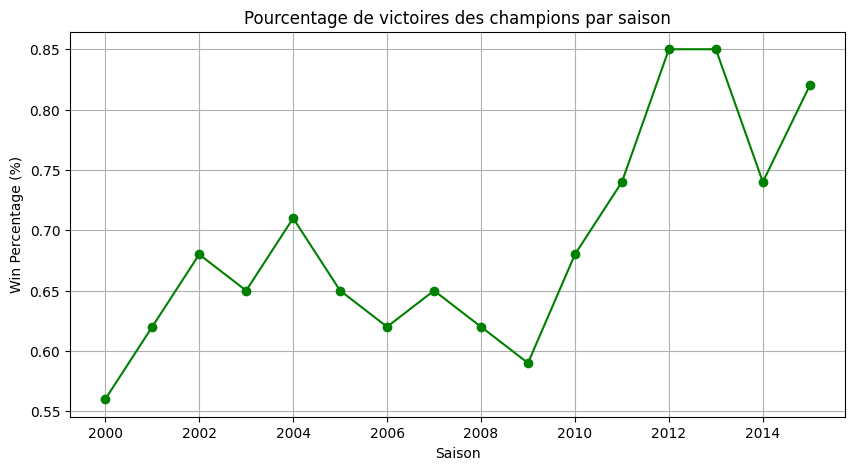

In [27]:
# % de victoires des champions
plt.figure(figsize=(10,5))
plt.plot(pdf_champions['Season'], pdf_champions['WinPercentage'], marker='o', color='green')
plt.title("Pourcentage de victoires des champions par saison")
plt.xlabel("Saison")
plt.ylabel("Win Percentage (%)")
plt.grid(True)
plt.show()


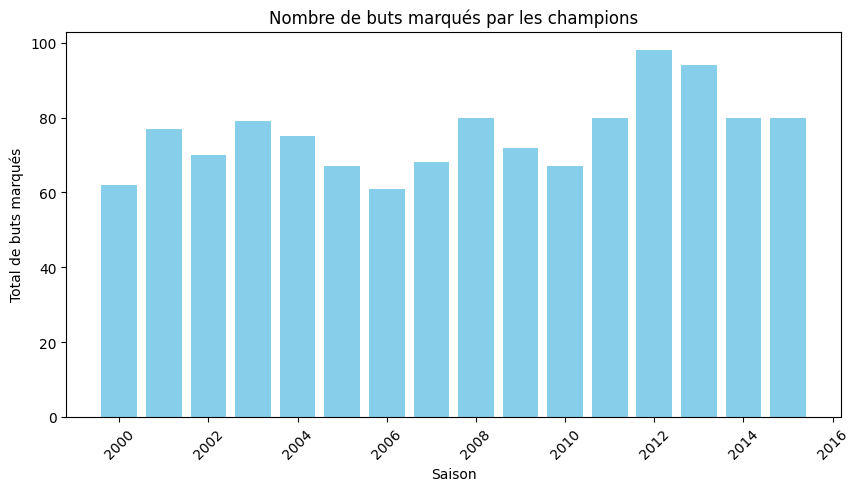

In [28]:
# Nombre de buts marqués.
plt.figure(figsize=(10,5))
plt.bar(pdf_champions['Season'], pdf_champions['GoalsScored'], color='skyblue')
plt.title("Nombre de buts marqués par les champions")
plt.xlabel("Saison")
plt.ylabel("Total de buts marqués")
plt.xticks(rotation=45)
plt.show()

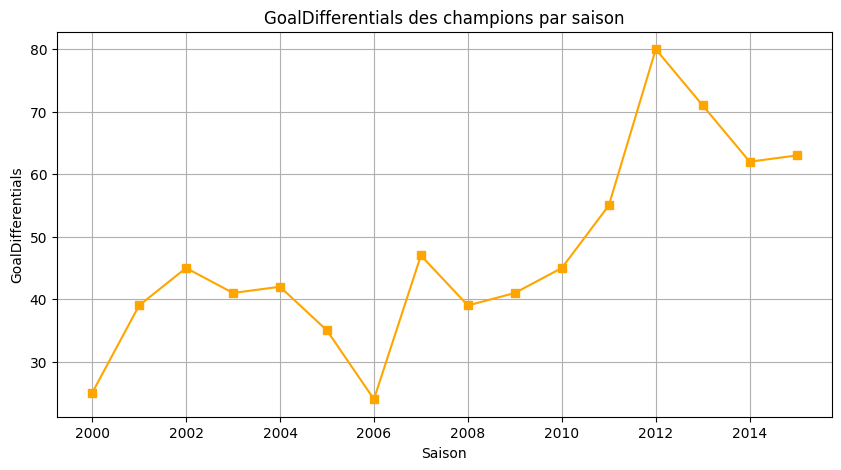

In [29]:
# GoalDifferentials par saison.
plt.figure(figsize=(10,5))
plt.plot(pdf_champions['Season'], pdf_champions['GoalDifferentials'], marker='s', color='orange')
plt.title("GoalDifferentials des champions par saison")
plt.xlabel("Saison")
plt.ylabel("GoalDifferentials")
plt.grid(True)
plt.show()
